# Team as an entity model (Fixed N)

This model is a

In [1]:
# Import
from torch import nn
from torch.utils.data import DataLoader, random_split

from models.models import *
from datasets.datasets import *
from utils import *

In [2]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
file = './Data/team/processed/team_data.xlsx'
dataset = get_team_dataset(file, NL=[5])

Targets
['W%', 'L%']
Normalizing features
[]
All features
['W%', 'L%', 'GF/G', 'GA/G', 'PIM/G', 'oPIM/G', 'S%', 'SV%']
Loading player data
creating dataset structure


Dataset size: (973, 10)
Feature: W%
Feature: L%


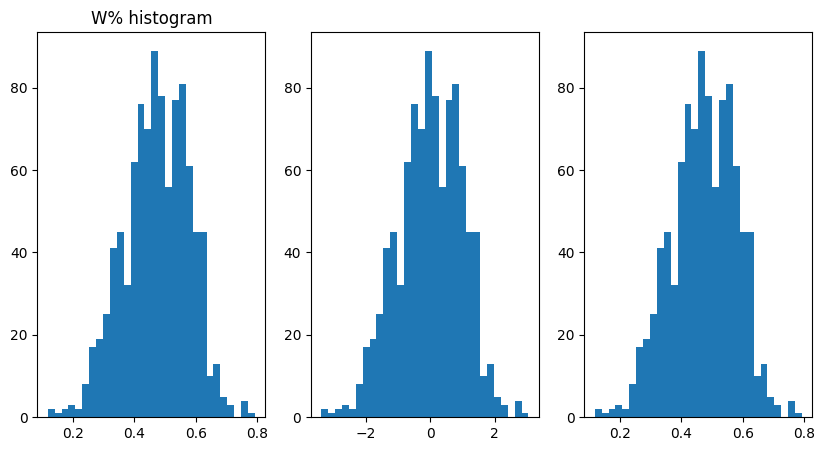

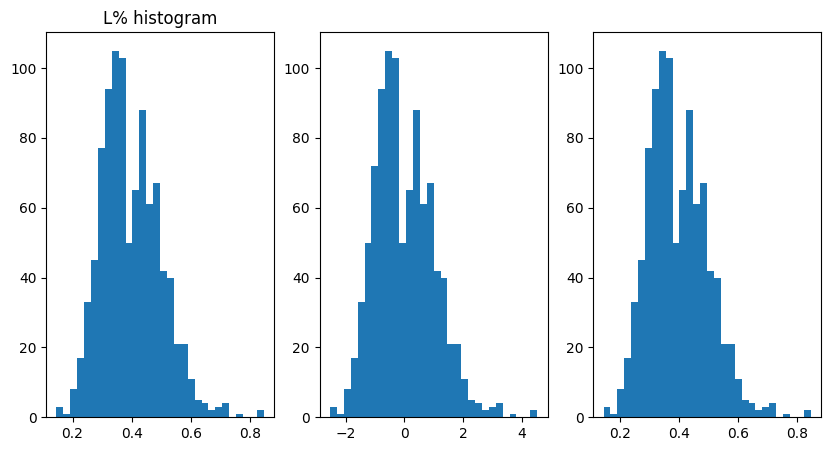

In [4]:
raw_dataset = dataset.alldata
raw_dataset_normalized = dataset.all_data_normalized

print(f"Dataset size: {raw_dataset.shape}")

for feature_name in dataset.col_names:
    if feature_name in dataset.targets:
        print(f"Feature: {feature_name}")
        feature = raw_dataset.loc[:, feature_name]
        feature_normalized = raw_dataset_normalized.loc[:, feature_name]
        features_unnormalized = dataset.unnormalize(torch.tensor(feature_normalized.values), feature_name)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.hist(feature, bins=30)
        plt.title(f"{feature_name} histogram")
        plt.subplot(1, 3, 2)
        plt.hist(feature_normalized, bins=30)
        plt.subplot(1, 3, 3)
        plt.hist(features_unnormalized, bins=30)

In [5]:
print(raw_dataset)
print(raw_dataset_normalized)

                 team name        W%        L%  GF/G  GA/G  PIM/G  oPIM/G  \
0            Boston Bruins  0.575000  0.312500  3.61  2.90   18.2    19.8   
1           Calgary Flames  0.525000  0.287500  4.35  3.31   21.9    20.3   
2           Buffalo Sabres  0.562500  0.337500  3.58  3.10   18.1    19.0   
3       Montreal Canadiens  0.512500  0.350000  3.60  2.93   19.9    20.7   
4          Edmonton Oilers  0.475000  0.350000  3.94  3.54   25.6    25.7   
..                     ...       ...       ...   ...   ...    ...     ...   
968        Ottawa Senators  0.412698  0.523810  3.17  3.51   10.9    11.6   
969  Columbus Blue Jackets  0.338462  0.507692  2.92  3.60    8.2     8.2   
970          Anaheim Ducks  0.353846  0.600000  2.58  3.62   14.3    11.9   
971     Chicago Blackhawks  0.272727  0.651515  2.18  3.55    9.0     9.9   
972        San Jose Sharks  0.250000  0.640625  2.19  3.88    9.7     8.2   

       S%    SV%  Season  
0    11.1  0.892    1990  
1    12.7  0.869    1

# Dataloader

In [6]:
batch_size = 100

# NOTE: we avoid contamination by training/testing with different players/teams
N_datasets = dataset.random_split(0.1)
dataset_train = TeamDataset(N_datasets[0][1],N=N_datasets[0][0])
dataset_test = TeamDataset(N_datasets[0][2],N=N_datasets[0][0])


# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

(tensor([[-0.1090,  0.2825,  1.8341,  1.5438,  1.3279,  1.2756,  1.8644, -1.6493],
        [-0.7063,  0.1565,  1.1607,  0.8819,  2.2195,  1.8293,  0.9603, -1.7329],
        [ 0.0105, -0.0954,  1.6483,  0.7495,  1.1922,  1.2953,  1.5356, -1.3147],
        [ 0.0219,  0.4384,  1.7876,  1.4556,  1.4635,  1.2756,  1.1247, -1.8166],
        [ 0.8183, -1.0009,  1.7180, -0.6184,  1.2891,  1.2162,  1.4534,  0.6090]]), tensor([-0.1488, -0.2213]))


In [7]:
print(len(N_datasets))
print(N_datasets[0][1][20])
print(len(N_datasets[0][2]))

1
(tensor([[-0.1002,  0.4237, -1.5794, -0.9714, -0.7657, -0.9195, -0.5193,  0.9436],
        [-1.2658,  0.9152, -1.6258,  0.0876, -0.7463, -0.8207, -1.5056,  0.2745],
        [ 0.5991, -0.4363,  0.1390,  0.0656, -1.0371, -1.0777, -0.3549,  0.4418],
        [-0.9161,  1.0381, -0.5344,  0.8819, -0.9208, -0.9591, -0.7659, -0.6456],
        [-0.6509,  0.2350, -0.5112,  0.7716, -0.8045, -0.9195, -0.8481, -0.1437]]), tensor([-1.2866,  1.3979]))
40


# Models

In [8]:
input_size = len(dataset_train.__getitem__(0)[0][0])
output_size = len(dataset_train.__getitem__(0)[1])
hidden_size = 50
#model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size, device=device).to(device)

"""
Hidden Layers Size Exploration
"""
#hidden_sizes = [5, 10, 20]
hidden_sizes = [5]


"""
Stacked LSTM Exploration
"""
#num_layerss = [1,2,3]
num_layerss = [1]

# Training and Validation

In [9]:
criterion = RMSELoss()
opt = torch.optim.Adam
epochs = 1000
loss_interval = 25

In [10]:
results = []

for hidden_size in hidden_sizes:
    for num_layers in num_layerss:

        print("\n####################")
        print(f"Model: {hidden_size}_{num_layers}")
        print("####################\n")

        model = TeamStandalone(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers, device=device).to(device)
        optimizer = opt(model.parameters(),lr=0.0001)
        
        res = train_and_validate(model, criterion, optimizer, dataloader_train, dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)
        results.append([(hidden_size,num_layers), res])


####################
Model: 5_1
####################



0 th epoch :  0.9898141324520111
Validation loss for epoch 0: 1.0466349124908447
Validation loss for epoch 25: 1.0264438390731812
50 th epoch :  0.9591750899950663
Validation loss for epoch 50: 0.9958823323249817
Validation loss for epoch 75: 0.9562414884567261
100 th epoch :  0.9017901321252187
Validation loss for epoch 100: 0.916438102722168
Validation loss for epoch 125: 0.8800021409988403
150 th epoch :  0.8411871492862701
Validation loss for epoch 150: 0.8510189652442932
Validation loss for epoch 175: 0.8308476209640503
200 th epoch :  0.8103661636511484
Validation loss for epoch 200: 0.818954348564148
Validation loss for epoch 225: 0.8117238283157349
250 th epoch :  0.7973138292630514
Validation loss for epoch 250: 0.8071681261062622
Validation loss for epoch 275: 0.8042379021644592
300 th epoch :  0.7913315196832021
Validation loss for epoch 300: 0.8021458983421326
Validation loss for epoch 325: 0.801071286201477
350 th epoch :  0.7878018915653229
Validation loss for epoch 350: 

# Plot Results

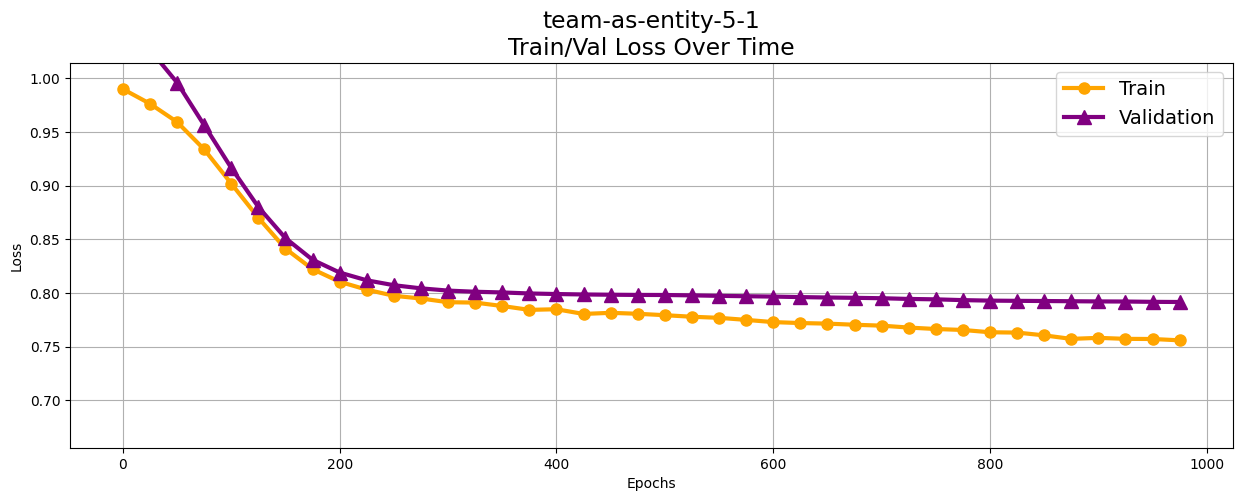

In [11]:
for res in  results:
    plot_train_v_loss(f"team-as-entity-{res[0][0]}-{res[0][1]}", res[1][1], res[1][2], loss_interval)

# Exploration results

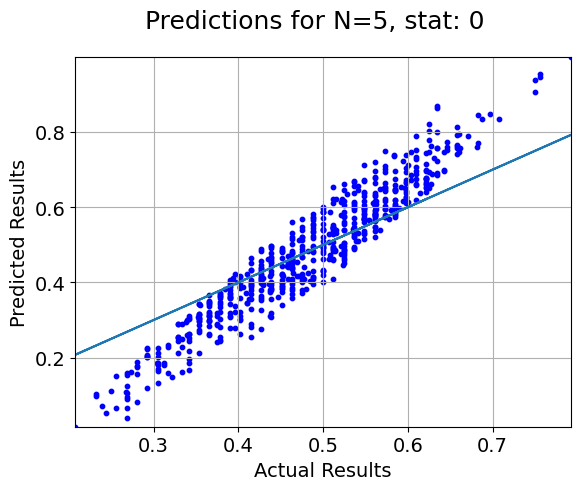

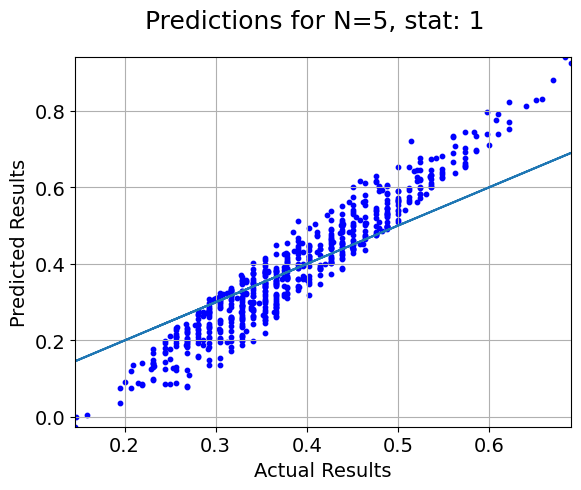

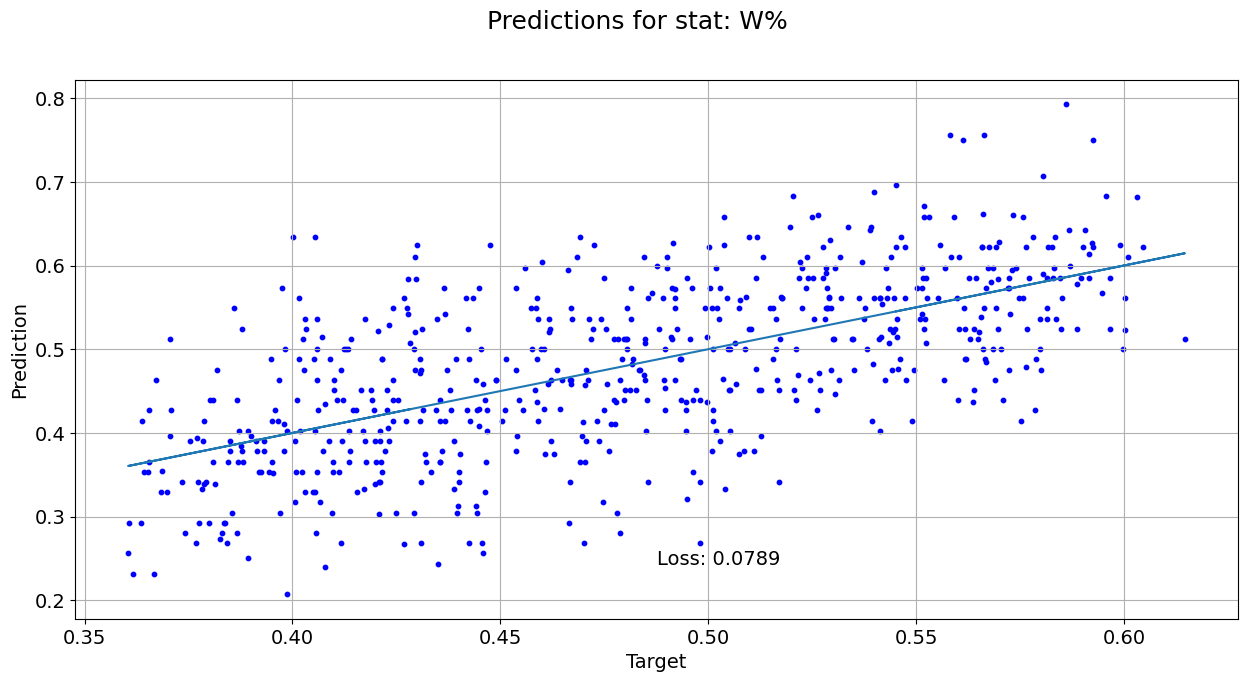

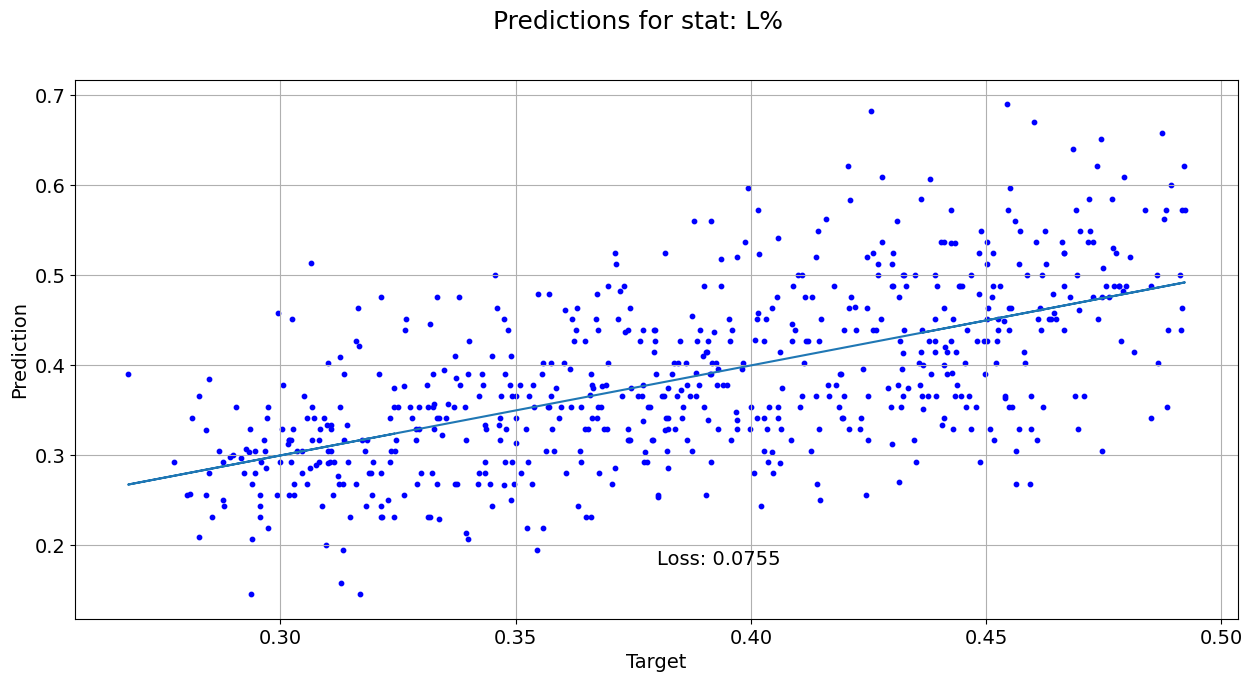

In [12]:
preds_n_targets = get_targets_preds_pairs(dataset, model, device)

#unnormalize
for pair in preds_n_targets:
    target = dataset.unnormalize(preds_n_targets[pair][0]) 
    pred = dataset.unnormalize(preds_n_targets[pair][1])
    preds_n_targets[pair] = (target, pred)
    
plot_divergence(dataset.NL, preds_n_targets, criterion, dataset.col_names)
plot_correlation(dataset.NL, preds_n_targets, criterion, dataset.col_names)